In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
from mpl_finance import candlestick2_ohlc, candlestick_ohlc
import matplotlib.dates as mdates

%matplotlib inline

In [2]:
codeList = ['A005930', 'A000660', 'A068270', 'A207940', 'A005380', 'A005490',\
            'A051910', 'A035420', 'A028260', 'A012330', 'A017670', 'A105560',\
            'A055550', 'A015760', 'A051900', 'A018260', 'A034730', 'A032830',\
            'A096770', 'A006400', 'A145020', 'A051370', 'A037460', 'A088800']
stName = ['삼성전자', 'SK하이닉스', '셀트리온', '삼성바이오로직스', '현대차', 'POSCO',\
          'LG화학', 'NAVER', '삼성물산', '현대모비스', 'SK텔레콤', 'KB금융', \
          '신한지주', '한국전력', 'LG생활건강', '삼성에스디에스', 'SK', '삼성생명',\
          'SK이노베이션', '삼성SDI', '휴젤', '인터플렉스', '삼지전자', '에이스테크']
Name2Code = {nm:code for nm, code in zip(stName, codeList)}
print(Name2Code)

{'삼성전자': 'A005930', '삼성생명': 'A032830', 'SK하이닉스': 'A000660', 'NAVER': 'A035420', 'SK텔레콤': 'A017670', 'KB금융': 'A105560', 'POSCO': 'A005490', 'SK이노베이션': 'A096770', '삼지전자': 'A037460', '삼성에스디에스': 'A018260', '신한지주': 'A055550', '인터플렉스': 'A051370', 'LG화학': 'A051910', '셀트리온': 'A068270', 'SK': 'A034730', '현대모비스': 'A012330', '삼성물산': 'A028260', 'LG생활건강': 'A051900', '삼성바이오로직스': 'A207940', '에이스테크': 'A088800', '삼성SDI': 'A006400', '한국전력': 'A015760', '현대차': 'A005380', '휴젤': 'A145020'}


In [19]:
nm = "삼성에스디에스"
close = pd.read_hdf('./daily_stock_price.h5', Name2Code[nm])
close.head(5)

date    open    high     low   close     vol     marketValue
date                                                                        
2016-08-22  20160822  169500  171500  165000  165500  124351  12805893000000
2016-08-23  20160823  165500  168000  160000  162000  167104  12535074000000
2016-08-24  20160824  161000  166000  159000  160500  148842  12419008000000
2016-08-25  20160825  160500  162500  159500  162000   80408  12535074000000
2016-08-26  20160826  162000  164000  161000  161000   82001  12457697000000

In [20]:
# trend condition
b_volume_ratio = close['vol'] >= close['vol'].rolling(20).mean() * 2.5
b_positive = close['close'] > close['open']
b_newhigh = close['close'] > close['close'].rolling(60).max() * 0.95
b_newhigh2 = close['close'].shift(1) != close['close'].rolling(60).max()
b_cond = b_volume_ratio & b_positive & b_newhigh & b_newhigh2

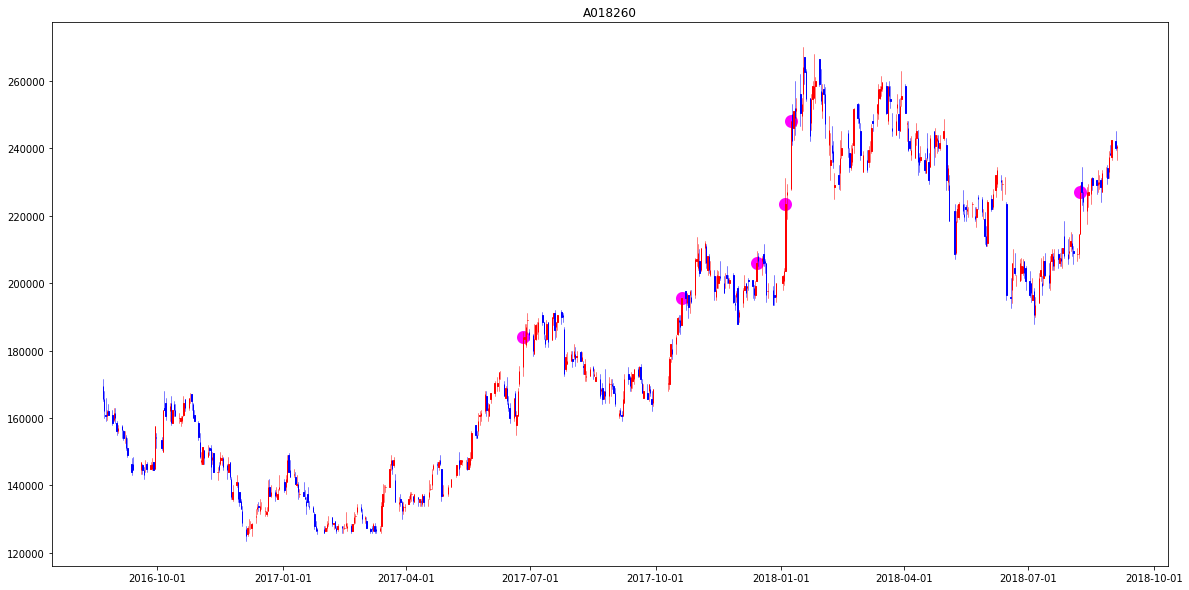

In [21]:
# Plot when signal is triggered!
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title(Name2Code[nm])
close['date'] = close.index.map(mdates.date2num)  # 그래프의 x축에 일자를 표시하기 위해 data 형태 변경
candlestick_ohlc(ax, close.loc[:, ['date', 'open', 'high', 'low', 'close']].values,\
                 colorup='red', colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.scatter(close.index[b_cond], close.loc[b_cond, "close"].values, c='fuchsia', linewidths=7)
# ax1.plot(close.index, close['vol'])

plt.show()

In [22]:
def cal_portion(f, profit, damping=0.2):
    if profit < 1:
        if f > damping:
            f_new = f - damping
        else:
            f_new = 0
    else:
        if f <= 1 - damping * 2:
            f_new = f + damping * 2
        else:
            f_new = 1
    return f_new

In [9]:
def simulation(b_cond, losscut_ratio=0.02, is_losscut=False, is_manage=False):
    profit = close['close']
    
    cummax = profit.iloc[0]
    bid_price = profit.iloc[0]
    close_done = True
    bid_done = False
    
    fee = pd.Series(np.ones_like(profit), index=profit.index)
    portions = pd.Series(np.ones_like(profit), index=profit.index)
    cummaxs = pd.Series(np.ones_like(profit), index=profit.index)
    
    n_trade = 0
    portion = 1.0
    is_capture = pd.Series(False, index=profit.index)

    plt.figure()
    profit.plot()
    plt.ion()

    for idx, bid in enumerate(b_cond.values):
        if bid and close_done:
            bid_price = profit.iloc[idx]
            cummax = bid_price
            bid_done = True
            close_done = False
            plt.scatter(b_cond.index[idx], bid_price, color='r')

        cummax = np.maximum(cummax, profit.iloc[idx])
        cummaxs[idx] = cummax

        is_maxdrop = cummax * (1 - 0.15) > profit.iloc[idx]

        if is_losscut:
            is_loss = bid_price * (1 - losscut_ratio) > profit.iloc[idx]
            is_maxdrop = is_maxdrop or is_loss

        if bid_done and is_maxdrop:
            ask_price = profit.iloc[idx]
            fee[idx] *= (1 - 0.0025)

            portion = cal_portion(portion, ask_price / bid_price * (1 - 0.0025))
            close_done = True
            bid_done = False
            plt.scatter(b_cond.index[idx], ask_price, color='c')
            n_trade += 1

        if bid_done and ~close_done and idx == b_cond.shape[0] - 1:
            ask_price = profit.iloc[idx]
            fee[idx] *= (1 - 0.0025)

            portion = cal_portion(portion, ask_price / bid_price * (1 - 0.0025))
            close_done = True
            bid_done = False
            plt.scatter(b_cond.index[idx], ask_price, color='c')
            n_trade += 1

        if is_manage:
            portions[idx] = portion

        if bid_done and ~close_done:
            is_capture[idx] = True

    cummaxs.plot()
    print("Total number of trade : %d" % (n_trade))
    return profit, portions, fee, is_capture

Total number of trade : 3
Total Profit : 1.0393 / MDD : -0.1869


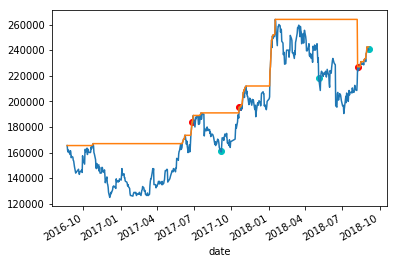

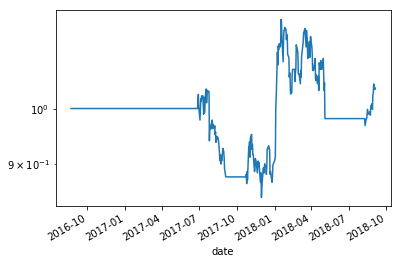

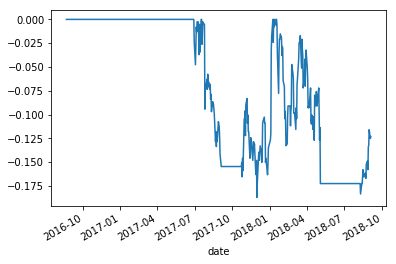

In [23]:
profit, portions, fee, is_capture = simulation(b_cond, is_losscut=False, is_manage=True)

prf = (profit.pct_change(1) + 1)
is_cap_ = is_capture.shift(1).fillna(False)
# print(is_capture)
prf *= fee.shift(1)

plt.figure("profit")
prf[~is_cap_] = 1.0
prf_cap = prf.cumprod()
prf_cap.plot(logy=True)

plt.figure("mdd")
mdd = (prf_cap - prf_cap.cummax()) / prf_cap.cummax()
mdd.plot()
print("Total Profit : {0:0.4f} / MDD : {1:0.4f}".format(prf_cap[-1], mdd.min()))